# Installations

In [ ]:
!pip install -U --pre tensorflow=="2.*"
!pip install tf_slim

In [ ]:
!pip install pycocotools

In [3]:
import os
import pathlib


if "models" in pathlib.Path.cwd().parts:
  while "models" in pathlib.Path.cwd().parts:
    os.chdir('..')
elif not pathlib.Path('models').exists():
  !git clone --depth 1 https://github.com/tensorflow/models

Cloning into 'models'...
remote: Enumerating objects: 2395, done.
remote: Counting objects: 100% (2395/2395), done.
remote: Compressing objects: 100% (1997/1997), done.
remote: Total 2395 (delta 567), reused 1384 (delta 371), pack-reused 0
Receiving objects: 100% (2395/2395), 30.77 MiB | 32.48 MiB/s, done.
Resolving deltas: 100% (567/567), done.


In [ ]:
%%bash
cd content/models/research/
protoc object_detection/protos/*.proto --python_out=.

In [ ]:
%%bash 
cd content/models/research
pip install .

# Imports

In [8]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image
from IPython.display import display

In [11]:
os.chdir('/content/models/research')

In [12]:
from object_detection.utils import ops as utils_ops
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

In [14]:
# patch tf1 into `utils.ops`
utils_ops.tf = tf.compat.v1

# Patch the location of gfile
tf.gfile = tf.io.gfile

# Model Preperartion

In [30]:
# loader 
def load_model(model_name):
  base_url = 'http://download.tensorflow.org/models/object_detection/'
  model_file = model_name + '.tar.gz'
  model_dir = tf.keras.utils.get_file(
    fname=model_name, 
    origin=base_url + model_file,
    untar=True)

  model_dir = pathlib.Path(model_dir)/"saved_model"

  model = tf.saved_model.load(str(model_dir))

  return model

#http://download.tensorflow.org/models/object_detection/tf2/20200711/efficientdet_d1_coco17_tpu-32.tar.gz

In [18]:
# loading label map

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = '/content/models/research/object_detection/data/mscoco_label_map.pbtxt'
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

In [ ]:
# loading test images
PATH_TO_TEST_IMAGES_DIR = pathlib.Path('/content/drive/MyDrive/Drone-Action/datasets/Drone-Action-Dataset/Extracted_Frames/boxing/S10_punching_toLeft_HD')
TEST_IMAGE_PATHS = sorted(list(PATH_TO_TEST_IMAGES_DIR.glob("*.jpg")))
TEST_IMAGE_PATHS

# Detection

In [ ]:
# load object detection model
model_name = 'ssd_mobilenet_v1_coco_2017_11_17'
#model_name = 'efficientdet_d0'
detection_model = load_model(model_name)
#http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v1_fpn_640x640_coco17_tpu-8.tar.gz

In [22]:
# Check the model's input signature, it expects a batch of 3-color images of type uint8:
print(detection_model.signatures['serving_default'].inputs)

[<tf.Tensor 'image_tensor:0' shape=(None, None, None, 3) dtype=uint8>]


In [23]:
detection_model.signatures['serving_default'].output_dtypes

{'detection_boxes': tf.float32,
 'detection_classes': tf.float32,
 'detection_scores': tf.float32,
 'num_detections': tf.float32}

In [24]:
detection_model.signatures['serving_default'].output_shapes

{'detection_boxes': TensorShape([None, 100, 4]),
 'detection_classes': TensorShape([None, 100]),
 'detection_scores': TensorShape([None, 100]),
 'num_detections': TensorShape([None])}

In [25]:
# add a wraper function to call the model and cleanup the outputs
def run_inference_for_single_image(model, image):
  image = np.asarray(image)
  # The input needs to be a tensor, convert it using `tf.convert_to_tensor`.
  input_tensor = tf.convert_to_tensor(image)
  # The model expects a batch of images, so add an axis with `tf.newaxis`.
  input_tensor = input_tensor[tf.newaxis,...]

  # Run inference
  model_fn = model.signatures['serving_default']
  output_dict = model_fn(input_tensor)

  # All outputs are batches tensors.
  # Convert to numpy arrays, and take index [0] to remove the batch dimension.
  # We're only interested in the first num_detections.
  num_detections = int(output_dict.pop('num_detections'))
  output_dict = {key:value[0, :num_detections].numpy() 
                 for key,value in output_dict.items()}
  output_dict['num_detections'] = num_detections

  # detection_classes should be ints.
  output_dict['detection_classes'] = output_dict['detection_classes'].astype(np.int64)
   
  # Handle models with masks:
  if 'detection_masks' in output_dict:
    # Reframe the the bbox mask to the image size.
    detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
              output_dict['detection_masks'], output_dict['detection_boxes'],
               image.shape[0], image.shape[1])      
    detection_masks_reframed = tf.cast(detection_masks_reframed > 0.5,
                                       tf.uint8)
    output_dict['detection_masks_reframed'] = detection_masks_reframed.numpy()
    
  return output_dict

Run on test images

In [26]:
def show_inference(model, image_path):
  # the array based representation of the image will be used later in order to prepare the
  # result image with boxes and labels on it.
  image_np = np.array(Image.open(image_path))
  # Actual detection.
  output_dict = run_inference_for_single_image(model, image_np)
  # Visualization of the results of a detection.
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks_reframed', None),
      use_normalized_coordinates=True,
      line_thickness=8)

  display(Image.fromarray(image_np))

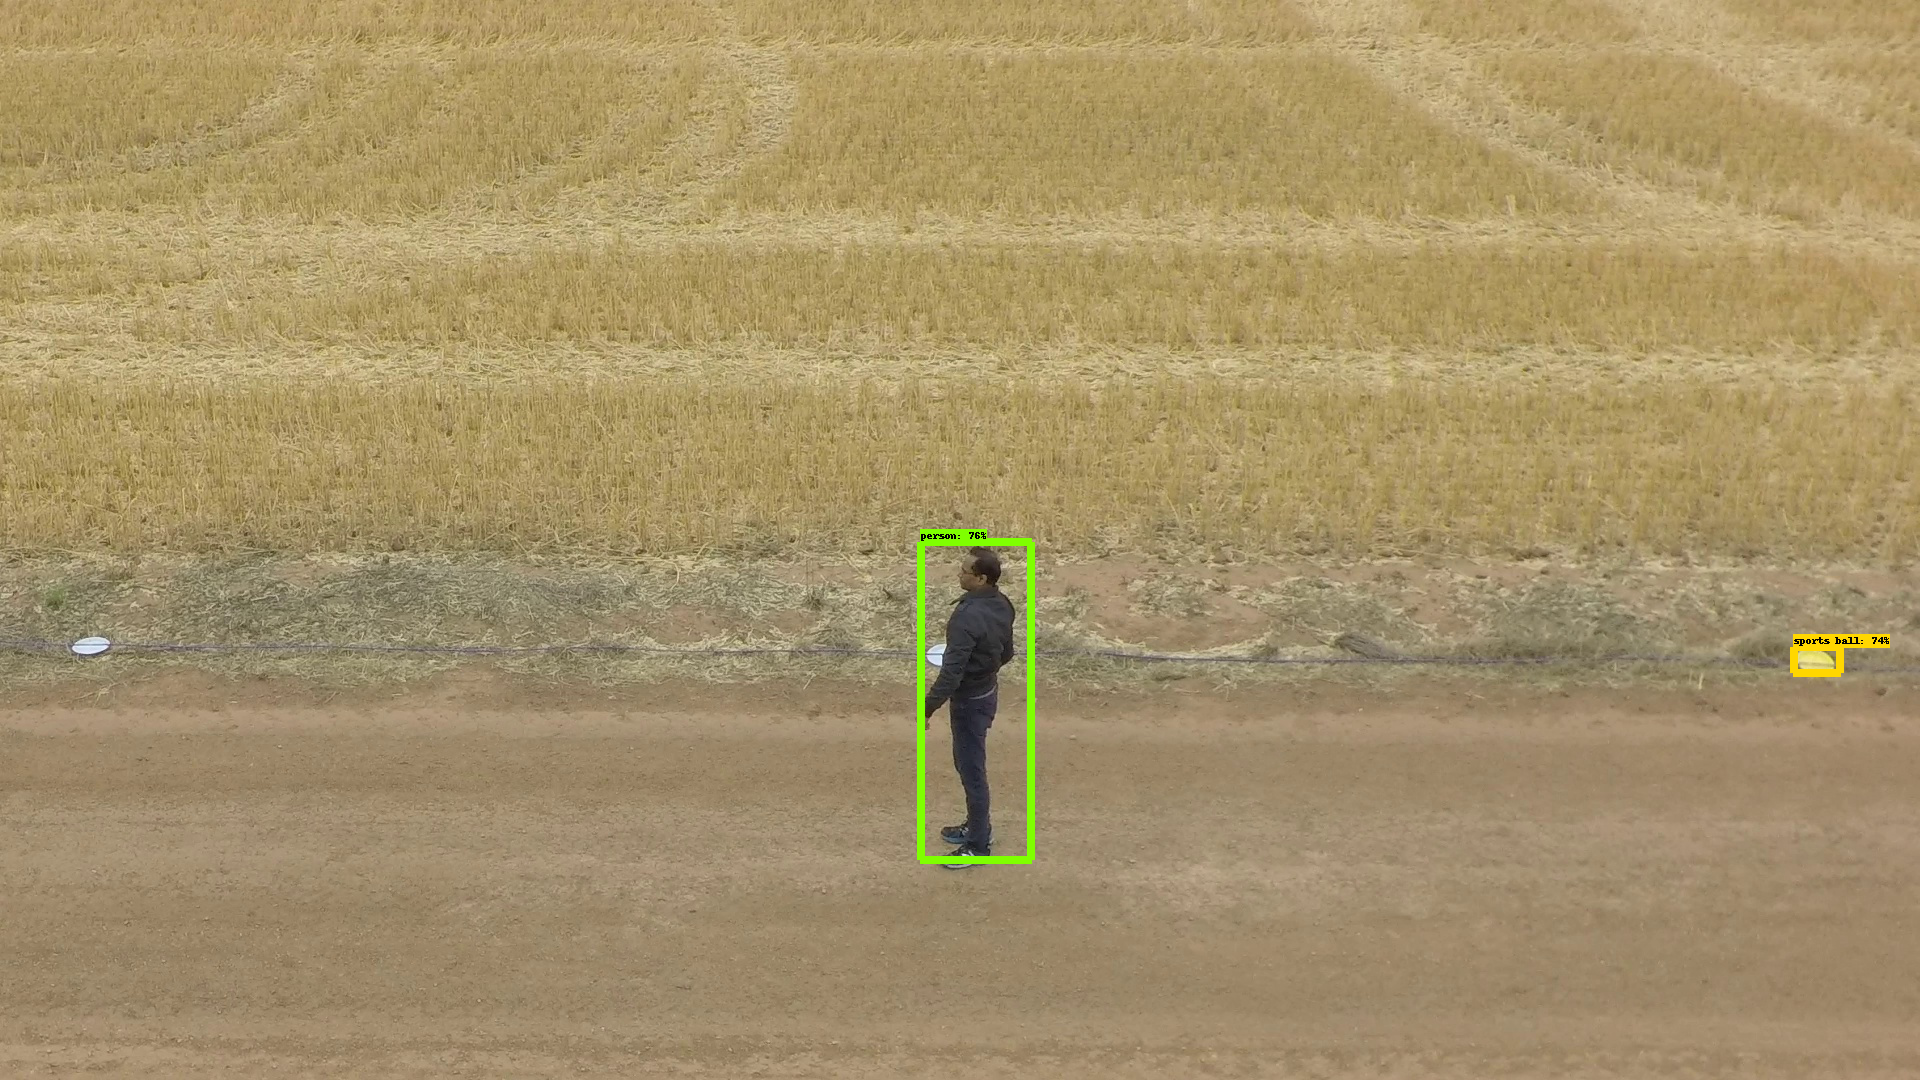

In [29]:
for image_path in TEST_IMAGE_PATHS:
  show_inference(detection_model, image_path)
  break